Experiment 1 with resnet18 transfer learning
============================================

In [1]:
from __future__ import print_function

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import csv
import gc
import torchnet as tnt
from utils import *
from classes import *
from tqdm import tqdm_notebook # for-loop progress bar in notebook

# plt setup and the gpu setup
plt.ion()
use_gpu = torch.cuda.is_available()

# load memory profiler
# %load_ext memory_profiler


print('main imports complete')

main imports complete


In [2]:
# ========================================
# Step 1. define data transform
#
# Including different forms of data augmentation
# One will include nearly all types (excluding random crops, etc. that may remove handwriting.)
# The other will include a selected set of augmentations
# Keeping 'train', 'val', and 'test' transforms just in case we want to include different functionalities
# ========================================

# Need the __name__ check to make multiprocessing work on Windows for some reason
# if __name__ == '__main__':
print("Set up data transforms.")
img_input_size = 56

selected_transforms = {
    'train': transforms.Compose([
        transforms.RandomHorizontalFlip(),
        # RandomRotation does not seem to be working on Windows right now
        transforms.RandomRotation(45),

        transforms.ColorJitter(brightness=0, contrast=0, saturation=0, hue=0.5),
        transforms.RandomGrayscale(p=0.1),

        transforms.Grayscale(), # not sure why the current input is not grayscale, do grayscale conversion
        transforms.Resize((img_input_size,img_input_size)),
        transforms.ToTensor(),
    ]),
    # should not do random transformation in val or test set
    'val': transforms.Compose([
        transforms.Grayscale(),
        transforms.Resize((img_input_size,img_input_size)),
        transforms.ToTensor(),
    ]),
    'test': transforms.Compose([
        transforms.Grayscale(),
        transforms.Resize((img_input_size,img_input_size)),
        transforms.ToTensor(),
    ]),
}

# Data augmentation and normalization for training
# Just normalization for validation
net1_data_transforms = {
    'train': transforms.Compose([
        #transforms.Resize(256),
        transforms.RandomResizedCrop(224), #apparently get an error if dont have this line
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),    
        transforms.Grayscale(),    
        transforms.ToTensor(),
        transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])
        #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.Grayscale(),
        transforms.ToTensor(),
        transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])
        #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        
    ]),
    
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.Grayscale(),
        transforms.ToTensor(),
        transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])
        #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        
    ]),
}

# data_transforms = selected_transforms
data_transforms = net1_data_transforms


Set up data transforms.


In [3]:
# ========================================
# Step 2. define and load data
#
# TODO: Suggest not using data loader to load the images. Because it is slow. Every epochs, you load the 
# image data again to the RAM and then from RAM to GPU RAM. That takes a lot of time. Since the images are 
# <1GB, you can preload the images into RAM first, that will make you training way faster. 

# Note: you only has about 200MB of images, it's small. It should not take much time to load!
# ========================================


print("Create dataset and dataloader")

# hyperparameter
# batch_size = 50 # larger batch size is better so you can load more data into gpu and train faster
batch_size = 50 # larger batch size is better so you can load more data into gpu and train faster

# data location
book_data_dir = '/home/rahul/data/printed_with_ids_harsh_filter/books-preprocessed-images'
set_types = ['train', 'val', 'test']

# Get the list of all books in the data set
books_in_data = set([b for b in os.listdir(book_data_dir)
                 if os.path.isdir(os.path.join(book_data_dir, b))])


print('Using default ImageFolder dataset.')
book_data_sets = {b : {t : datasets.ImageFolder(os.path.join(book_data_dir, b), 
                                                transform = data_transforms[t])#, transform=test_transform)
                      for t in set_types}
                 for b in books_in_data}

# create a dict of dataloaders, book_data_loaders['Albin']['train']
book_data_loaders = {b : {t : torch.utils.data.DataLoader(book_data_sets[b][t],
                                                          batch_size=batch_size,
                                                          shuffle=True, # make sure you shuffle the data
                                                          num_workers=4)
                          for t in set_types}
                     for b in books_in_data}



print('Counting images')
no_transform_datasets = {b : datasets.ImageFolder(os.path.join(book_data_dir, b)) for b in books_in_data}
image_counts = {book : {0 : 0, 1 : 0} for book in no_transform_datasets}
for book in no_transform_datasets:
    for im, target in no_transform_datasets[book]:
        image_counts[book][target] += 1
        
print(image_counts)

print("data loading complete")



Create dataset and dataloader
Using default ImageFolder dataset.
Counting images
{'Ascham': {0: 20, 1: 76}, 'Voltaire': {0: 55, 1: 305}, 'Blackmore': {0: 36, 1: 292}, 'Montaigne': {0: 129, 1: 538}, 'Allestree': {0: 66, 1: 212}, 'Browne': {0: 160, 1: 200}, 'Albin': {0: 143, 1: 31}, 'Dryden': {0: 39, 1: 9}, 'Defoe': {0: 107, 1: 229}, 'Confucius': {0: 6, 1: 165}}
data loading complete


In [4]:
# 
# ========================================
# Check your data to make sure it is correct
# ========================================

# for data in book_data_loaders['Defoe']['train']:
#     # get the inputs
#     inputs, labels = data

#     # plot to verify the input is correct
#     input1 = inputs[0].numpy()
#     print(input1.shape)
#     input1 = np.swapaxes(input1,0,2).squeeze()
#     print(input1.shape)
#     plt.imshow(input1,cmap='gray')

#     break

In [5]:
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import lr_scheduler
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#from https://github.com/pytorch/examples/blob/master/mnist/main.py
class JQNet1(nn.Module):
    def __init__(self):
        super(JQNet1, self).__init__()
        if use_gpu:
            self.conv1 = nn.Conv2d(1, 10, kernel_size=3, padding = 1).cuda()
            self.conv2 = nn.Conv2d(10, 20, kernel_size=3, padding = 1).cuda()
            self.conv3 = nn.Conv2d(20, 40, kernel_size=3, padding = 1).cuda()
            self.conv2_drop = nn.Dropout2d(p = 0.2)
            self.conv3_drop = nn.Dropout2d(p = 0.1)

            #assumes a batch size of 50
            self.fc1 = nn.Linear(31360,64).cuda()
            self.fc2 = nn.Linear(64, 25).cuda()
            self.fc3 = nn.Linear(25,2).cuda()
        else:
            self.conv1 = nn.Conv2d(1, 10, kernel_size=3, padding = 1).cpu()
            self.conv2 = nn.Conv2d(10, 20, kernel_size=3, padding = 1).cpu()
            self.conv3 = nn.Conv2d(20, 40, kernel_size=3, padding = 1).cpu()
            self.conv2_drop = nn.Dropout2d(p = 0.2)
            self.conv3_drop = nn.Dropout2d(p = 0.1)

            #assumes a batch size of 50
            self.fc1 = nn.Linear(31360,64).cpu()
            self.fc2 = nn.Linear(64, 25).cpu()
            self.fc3 = nn.Linear(25,2).cpu()

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = F.relu(F.max_pool2d(self.conv3_drop(self.conv3(x)), 2))
        
        x = x.view(x.size(0),-1) #clutch line
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        
        
        x = x.view(x.size(0),-1) #clutch line
        x = F.relu(self.fc2(x))
        x = F.dropout(x, training=self.training)
        
        x = self.fc3(x)
        return F.log_softmax(x, dim=1)
        #return x

In [6]:
# ========================================
# Step 3. define model structure
#
# TODO: Stick with MNIST for now because it is smaller network and faster to train. Note that you lose
# a lot of inofmration when yo udownsample the image to 28x28. THat's okay, you optimize other parts first, e.g.,
# data loading before you optimize your model.
# ========================================
from lib.playground.utee import selector
from lib.playground.mnist import model
import os

def create_model_architecture(model_type='mnist'):
    """
    params model_type: the type of model, for now, support mnist and resnet18    
    """
    if model_type == 'mnist':
        print('using pretrained mnist model')
        
        # load the model from the playground library
        model_annotation, ds_fetcher, is_imagenet = selector.select('mnist')
        
        # remove last layer
        removed = list(model_annotation.model.children())[:-1]
        
        # add a front layer to account for new input
        # IMPORTANT, we need to update the self.input_dims of the MLP class
        removed = [nn.Linear(img_input_size*img_input_size,28*28), nn.ReLU()] + removed
        
        # formulate the layers
        model_annotation.model=torch.nn.Sequential(*removed)
        
        # add the new fc layer
        model_annotation.model.fc = torch.nn.Linear(256,2).cuda()
        
        # update the self.input_dims of the network
        model_annotation.input_dims = img_input_size * img_input_size                

    elif model_type == 'resnet18':    
        print("Transferring resnet18 and retraining with annotations dataset.")    
        model_annotation = models.resnet18(pretrained=True)
        num_params = sum(1 for i in model_annotation.parameters())

        # There are 10 layers (model_ft.children()) in resnet18
        # Freezing the first half of resnet18, freezing all params for layers 1-5
        max_layer = 5
        curr_layer = 1
        last_layer = None
        for child in model_annotation.children():
            if curr_layer <= max_layer:
                for param in child.parameters():
                    param.requires_grad = False
                last_layer = child
                curr_layer = curr_layer + 1
            else:
                break

        # Replace the final fully connected layer to perform binary classification
        num_ftrs = model_annotation.fc.in_features
        model_annotation.fc = nn.Linear(num_ftrs, 2)
        
    elif model_type == 'jq_net1':
        print("Creating JQ's net1.")
        model_annotation = JQNet1()
        

    # return
    if use_gpu:
        return model_annotation.cuda()
    else:
        return model_annotation.cpu()


In [7]:
def safe_div(n1, n2):
    if n2 == 0:
        return 0
    return n1/n2

In [8]:
def compute_f1_score(tn, fp, fn, tp, class_type='pos'):
    if class_type == 'pos':
        prec   = safe_div(float(tp),(float(tp) + float(fp)))
        recall = safe_div(float(tp),(float(tp) + float(fn)))
    elif class_type == 'neg':
        prec   = safe_div(float(tn),(float(tn) + float(fn)))
        recall = safe_div(float(tn),(float(tn) + float(fp)))
        
    return safe_div(float(2) * (prec * recall), (prec + recall))

In [9]:
# ========================================
# Step 4. define the training process.
#
# TODO: The basic process of train and validation is defined. Please implement the overall average validation 
# confusion matrix, meaning for each validation (after running all epochs), get the confusion matrix for that book,
# repeat this for the rest of 10 books. THen get the overall performance. Also, implement the early-stop as you
# originally has in your code. :) I removed them here for clarity. You can add them back. 
# ========================================


def train(model, criterion, optimizer, data_loaders, num_epochs=25, early_stopping = None):    
    since = time.time()
    
    # number of samples for normalization of loss
    num_samples = {p : sum([len(data_loaders[p][b].dataset) for b in data_loaders[p]]) for p in ['train', 'val']}
    
    # accumulate metrics
    metric_names = [p+'-'+m for p in ['train', 'val'] for m in ['loss', 'tn', 'fp', 'fn', 'tp', 'f1_pos', 'f1_neg']]
    metrics_dict = {m : [] for m in metric_names}
    # stop the training, validation, and test loop
    for epoch in range(num_epochs):
        print()
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        # looping parameters
#         running_loss = 0.0
#         running_corrects = 0
#         confusion_matrix = tnt.meter.ConfusionMeter(2)
        
        # loop through train and val phase in each epoch
        for phase in ['train', 'val']:
            # check train or val
            if phase == 'train':                
                model.train(True)  # Set model to training mode
            else:
                model.train(False)  # Set model to evaluate mode

            # initialize variables needed for metrics per epoch
            running_loss = 0.0
            confusion_matrix = tnt.meter.ConfusionMeter(2)
            
            # Iterate over each book
            for book in data_loaders[phase]:
                for data in data_loaders[phase][book]:
                    
                    # get the inputs;  wrap them in Variable and make them into gpu or not
                    inputs, labels = data # input size: [5, 1, 28, 28] ; keep the dummy color channel:1
                    if use_gpu:
                        inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
                    else:
                        inputs, labels = Variable(inputs), Variable(labels)
                    
                    # zero the parameter gradients
                    optimizer.zero_grad()
                    
                    with torch.set_grad_enabled(phase == 'train'):
                        # forward
                        outputs = model(inputs)
                        _, preds = torch.max(outputs.data, 1)
                        loss = criterion(outputs, labels)

                        # back
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                        # Add to confusion matrix
                        confusion_matrix.add(outputs.data, labels.data)

                    # statistics
                    # Including inputs.size(0) scales the loss by the size of the batch
                    running_loss += (loss.item() * inputs.size(0))
            
            
            # compute evaluation
            epoch_loss = float(running_loss) / float(num_samples[phase])
            conf_tn    = confusion_matrix.conf[0][0]
            conf_fp    = confusion_matrix.conf[0][1]
            conf_fn    = confusion_matrix.conf[1][0]
            conf_tp    = confusion_matrix.conf[1][1]
            epoch_f1_p = compute_f1_score(conf_tn, conf_fp, conf_fn, conf_tp, class_type='pos')
            epoch_f1_n = compute_f1_score(conf_tn, conf_fp, conf_fn, conf_tp, class_type='neg')
            
            
            # accumulate metrics
            metrics_dict[phase+'-loss'].append(epoch_loss)
            metrics_dict[phase+'-tn'].append(conf_tn)
            metrics_dict[phase+'-fp'].append(conf_fp)
            metrics_dict[phase+'-fn'].append(conf_fn)
            metrics_dict[phase+'-tp'].append(conf_tp)
            metrics_dict[phase+'-f1_pos'].append(epoch_f1_p)
            metrics_dict[phase+'-f1_neg'].append(epoch_f1_n)
            
            # report evaluation
            print('Phase:%s' %phase)
            print('average loss', running_loss)
            print('f1_pos', epoch_f1_p)
            print('f1_neg', epoch_f1_n)

    
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    
    # return both the trained model and the metrics
    return model, metrics_dict

In [10]:
def plot_values(train_values, val_values, title, ylabel='Loss'):
    plt.plot(train_values,label = "train")
    plt.plot(val_values,label = "validation")
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel("Epochs")
    plt.legend()
    plt.show()


    print("Average Training Score: " + str(np.mean(train_values)))
    print("Average Validation Score: " + str(np.mean(val_values)))

In [11]:
def write_metrics_to_csv(raw_metrics, metric_names, dirname, filename):
    import csv
    import os
    
    if not os.path.exists(dirname):
        os.makedirs(dirname)
        
    fileloc = os.path.join(dirname, filename)
    with open(fileloc, 'w') as outfile:
        filewriter = csv.writer(outfile, delimiter=',')
        filewriter.writerow(metric_names)
        for epoch in range(len(raw_metrics[metric_names[0]])):
            newrow = [raw_metrics[metric][epoch] for metric in metric_names]
            filewriter.writerow(newrow)
            
    print("Wrote metrics to '" + str(fileloc) + "'")
    return

use_gpu is True
validating on book: 'Ascham'
Creating JQ's net1.
train counts {0: 741, 1: 1981}

Epoch 0/99
----------
Phase:train
average loss 2038.292908191681
f1_pos 0.7356562745611738
f1_neg 0.379840196681008
Phase:val
average loss 68.90792083740234
f1_pos 0
f1_neg 0.3448275862068966

Epoch 1/99
----------
Phase:train
average loss 1883.7695778608322
f1_pos 0.6337950138504156
f1_neg 0.2791712104689204
Phase:val
average loss 67.74432110786438
f1_pos 0
f1_neg 0.3448275862068966

Epoch 2/99
----------
Phase:train
average loss 1941.2639204859734
f1_pos 0.6240601503759398
f1_neg 0.186046511627907
Phase:val
average loss 66.97521507740021
f1_pos 0
f1_neg 0.3448275862068966

Epoch 3/99
----------
Phase:train
average loss 1915.5890043973923
f1_pos 0.7541442913845435
f1_neg 0.09302325581395349
Phase:val
average loss 66.55350244045258
f1_pos 0
f1_neg 0.3448275862068966

Epoch 4/99
----------
Phase:train
average loss 1910.5664954781532
f1_pos 0.8351601117558565
f1_neg 0.03034134007585335
Phase:

Phase:train
average loss 1903.605043053627
f1_pos 0.8424409951095045
f1_neg 0
Phase:val
average loss 66.18315124511719
f1_pos 0.8837209302325582
f1_neg 0

Epoch 46/99
----------
Phase:train
average loss 1907.7874355912209
f1_pos 0.8424409951095045
f1_neg 0
Phase:val
average loss 66.14594638347626
f1_pos 0.8837209302325582
f1_neg 0

Epoch 47/99
----------
Phase:train
average loss 1907.5783344507217
f1_pos 0.8424409951095045
f1_neg 0
Phase:val
average loss 66.08883917331696
f1_pos 0.8837209302325582
f1_neg 0

Epoch 48/99
----------
Phase:train
average loss 1910.6804733872414
f1_pos 0.8424409951095045
f1_neg 0
Phase:val
average loss 66.03871655464172
f1_pos 0.8837209302325582
f1_neg 0

Epoch 49/99
----------
Phase:train
average loss 1903.894914984703
f1_pos 0.8424409951095045
f1_neg 0
Phase:val
average loss 66.18569803237915
f1_pos 0.8837209302325582
f1_neg 0

Epoch 50/99
----------
Phase:train
average loss 1911.8998157382011
f1_pos 0.8424409951095045
f1_neg 0
Phase:val
average loss 66.13

Phase:train
average loss 1906.903093457222
f1_pos 0.8424409951095045
f1_neg 0
Phase:val
average loss 66.2284586429596
f1_pos 0.8837209302325582
f1_neg 0

Epoch 92/99
----------
Phase:train
average loss 1907.7357365489006
f1_pos 0.8424409951095045
f1_neg 0
Phase:val
average loss 66.28162801265717
f1_pos 0.8837209302325582
f1_neg 0

Epoch 93/99
----------
Phase:train
average loss 1906.5918105840683
f1_pos 0.8424409951095045
f1_neg 0
Phase:val
average loss 66.29656875133514
f1_pos 0.8837209302325582
f1_neg 0

Epoch 94/99
----------
Phase:train
average loss 1910.1836312413216
f1_pos 0.8424409951095045
f1_neg 0
Phase:val
average loss 66.21661245822906
f1_pos 0.8837209302325582
f1_neg 0

Epoch 95/99
----------
Phase:train
average loss 1911.7534447312355
f1_pos 0.8424409951095045
f1_neg 0
Phase:val
average loss 66.002645611763
f1_pos 0.8837209302325582
f1_neg 0

Epoch 96/99
----------
Phase:train
average loss 1907.961658000946
f1_pos 0.8424409951095045
f1_neg 0
Phase:val
average loss 66.05470

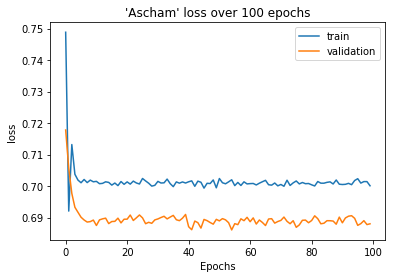

Average Training Score: 0.7015222443437682
Average Validation Score: 0.6895691137636701


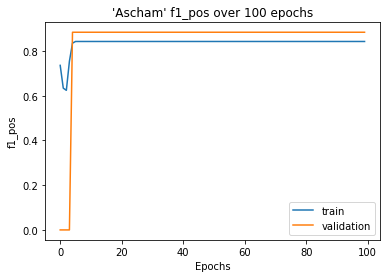

Average Training Score: 0.8361471037733084
Average Validation Score: 0.8483720930232557


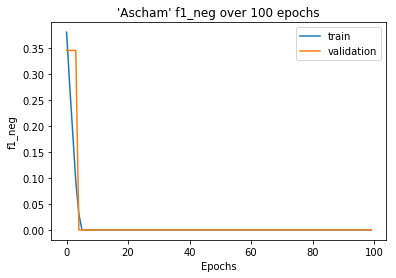

Average Training Score: 0.009684225146676422
Average Validation Score: 0.013793103448275864
Wrote metrics to 'raw_logs/Ascham.csv'

validating on book: 'Voltaire'
Creating JQ's net1.
train counts {0: 706, 1: 1752}

Epoch 0/99
----------
Phase:train
average loss 1876.9316538572311
f1_pos 0.6373103243082416
f1_neg 0.21607717041800642
Phase:val
average loss 258.5428708791733
f1_pos 0
f1_neg 0.26506024096385544

Epoch 1/99
----------
Phase:train
average loss 1737.8872406482697
f1_pos 0.6727777777777778
f1_neg 0.1048632218844985
Phase:val
average loss 250.81859290599823
f1_pos 0
f1_neg 0.26506024096385544

Epoch 2/99
----------
Phase:train
average loss 1728.5612448453903
f1_pos 0.8001975796492962
f1_neg 0.06689734717416379
Phase:val
average loss 247.93354392051697
f1_pos 0.9172932330827067
f1_neg 0

Epoch 3/99
----------
Phase:train
average loss 1726.8717406392097
f1_pos 0.8323040380047506
f1_neg 0
Phase:val
average loss 246.17264986038208
f1_pos 0.9172932330827067
f1_neg 0

Epoch 4/99
----

Phase:val
average loss 245.50915241241455
f1_pos 0.9172932330827067
f1_neg 0

Epoch 45/99
----------
Phase:train
average loss 1722.1739931702614
f1_pos 0.8323040380047506
f1_neg 0
Phase:val
average loss 245.6751948595047
f1_pos 0.9172932330827067
f1_neg 0

Epoch 46/99
----------
Phase:train
average loss 1722.8236218094826
f1_pos 0.8323040380047506
f1_neg 0
Phase:val
average loss 245.82031846046448
f1_pos 0.9172932330827067
f1_neg 0

Epoch 47/99
----------
Phase:train
average loss 1723.7770215272903
f1_pos 0.8323040380047506
f1_neg 0
Phase:val
average loss 245.6918317079544
f1_pos 0.9172932330827067
f1_neg 0

Epoch 48/99
----------
Phase:train
average loss 1722.9031267166138
f1_pos 0.8323040380047506
f1_neg 0
Phase:val
average loss 244.9451643228531
f1_pos 0.9172932330827067
f1_neg 0

Epoch 49/99
----------
Phase:train
average loss 1721.5484373569489
f1_pos 0.8323040380047506
f1_neg 0
Phase:val
average loss 246.3270139694214
f1_pos 0.9172932330827067
f1_neg 0

Epoch 50/99
----------
Pha

Phase:val
average loss 247.16860949993134
f1_pos 0.9172932330827067
f1_neg 0

Epoch 91/99
----------
Phase:train
average loss 1722.573793888092
f1_pos 0.8323040380047506
f1_neg 0
Phase:val
average loss 246.1848783493042
f1_pos 0.9172932330827067
f1_neg 0

Epoch 92/99
----------
Phase:train
average loss 1722.2996249198914
f1_pos 0.8323040380047506
f1_neg 0
Phase:val
average loss 245.59196889400482
f1_pos 0.9172932330827067
f1_neg 0

Epoch 93/99
----------
Phase:train
average loss 1722.1581554412842
f1_pos 0.8323040380047506
f1_neg 0
Phase:val
average loss 245.12860655784607
f1_pos 0.9172932330827067
f1_neg 0

Epoch 94/99
----------
Phase:train
average loss 1722.7062813043594
f1_pos 0.8323040380047506
f1_neg 0
Phase:val
average loss 246.29152119159698
f1_pos 0.9172932330827067
f1_neg 0

Epoch 95/99
----------
Phase:train
average loss 1723.3301393389702
f1_pos 0.8323040380047506
f1_neg 0
Phase:val
average loss 246.38690948486328
f1_pos 0.9172932330827067
f1_neg 0

Epoch 96/99
----------
P

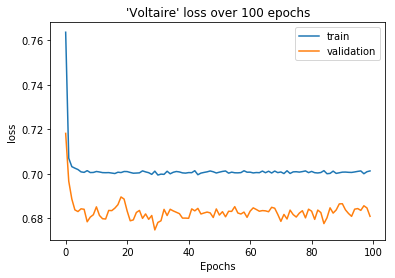

Average Training Score: 0.7014377190333928
Average Validation Score: 0.6830737386147182


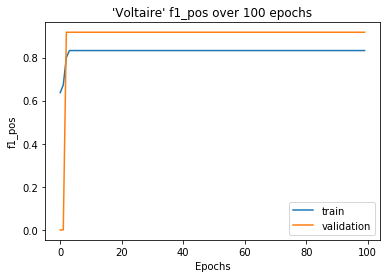

Average Training Score: 0.828437773681961
Average Validation Score: 0.8989473684210523


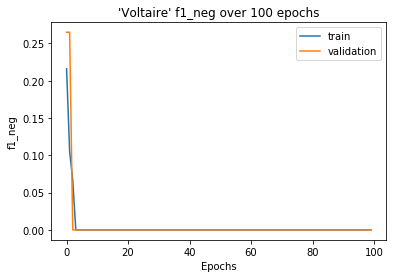

Average Training Score: 0.0038783773947666873
Average Validation Score: 0.005301204819277109
Wrote metrics to 'raw_logs/Voltaire.csv'

validating on book: 'Blackmore'
Creating JQ's net1.
train counts {0: 725, 1: 1765}

Epoch 0/99
----------
Phase:train
average loss 2216.5971767902374
f1_pos 0.7225186766275348
f1_neg 0.15584415584415587
Phase:val
average loss 236.4087542295456
f1_pos 0
f1_neg 0.1978021978021978

Epoch 1/99
----------
Phase:train
average loss 1760.8827071785927
f1_pos 0.6991126646948104
f1_neg 0.11260904044409199
Phase:val
average loss 228.49168646335602
f1_pos 0
f1_neg 0.1978021978021978

Epoch 2/99
----------
Phase:train
average loss 1754.8147603869438
f1_pos 0.761661993372419
f1_neg 0.11542100283822139
Phase:val
average loss 228.12001705169678
f1_pos 0
f1_neg 0.1978021978021978

Epoch 3/99
----------
Phase:train
average loss 1746.0662314295769
f1_pos 0.8206224756474222
f1_neg 0.020752269779507133
Phase:val
average loss 220.06413757801056
f1_pos 0.9419354838709678
f1_n

Phase:train
average loss 1741.9042088985443
f1_pos 0.8296122209165688
f1_neg 0
Phase:val
average loss 225.11925292015076
f1_pos 0.9419354838709678
f1_neg 0

Epoch 45/99
----------
Phase:train
average loss 1745.686098396778
f1_pos 0.8296122209165688
f1_neg 0
Phase:val
average loss 221.92973256111145
f1_pos 0.9419354838709678
f1_neg 0

Epoch 46/99
----------
Phase:train
average loss 1743.483049750328
f1_pos 0.8296122209165688
f1_neg 0
Phase:val
average loss 222.37864756584167
f1_pos 0.9419354838709678
f1_neg 0

Epoch 47/99
----------
Phase:train
average loss 1745.662869155407
f1_pos 0.8296122209165688
f1_neg 0
Phase:val
average loss 221.98086404800415
f1_pos 0.9419354838709678
f1_neg 0

Epoch 48/99
----------
Phase:train
average loss 1744.65579277277
f1_pos 0.8296122209165688
f1_neg 0
Phase:val
average loss 222.49417293071747
f1_pos 0.9419354838709678
f1_neg 0

Epoch 49/99
----------
Phase:train
average loss 1744.2565557956696
f1_pos 0.8296122209165688
f1_neg 0
Phase:val
average loss 222

Phase:train
average loss 1744.735671877861
f1_pos 0.8296122209165688
f1_neg 0
Phase:val
average loss 223.45058929920197
f1_pos 0.9419354838709678
f1_neg 0

Epoch 91/99
----------
Phase:train
average loss 1743.546976864338
f1_pos 0.8296122209165688
f1_neg 0
Phase:val
average loss 223.9354841709137
f1_pos 0.9419354838709678
f1_neg 0

Epoch 92/99
----------
Phase:train
average loss 1744.7659224271774
f1_pos 0.8296122209165688
f1_neg 0
Phase:val
average loss 222.0634925365448
f1_pos 0.9419354838709678
f1_neg 0

Epoch 93/99
----------
Phase:train
average loss 1745.8352951407433
f1_pos 0.8296122209165688
f1_neg 0
Phase:val
average loss 220.99208116531372
f1_pos 0.9419354838709678
f1_neg 0

Epoch 94/99
----------
Phase:train
average loss 1741.1425255537033
f1_pos 0.8296122209165688
f1_neg 0
Phase:val
average loss 224.29733669757843
f1_pos 0.9419354838709678
f1_neg 0

Epoch 95/99
----------
Phase:train
average loss 1743.2170197367668
f1_pos 0.8296122209165688
f1_neg 0
Phase:val
average loss 22

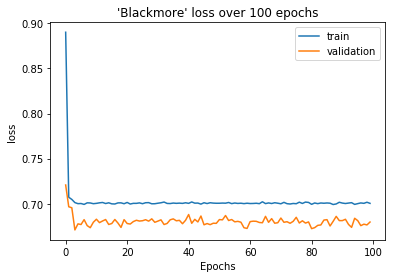

Average Training Score: 0.7025556969702482
Average Validation Score: 0.6804459281411113


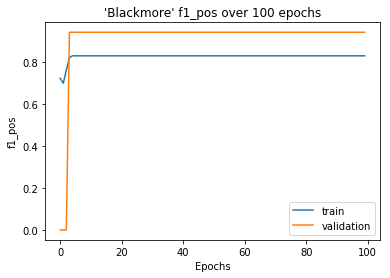

Average Training Score: 0.8264668901833281
Average Validation Score: 0.9136774193548385


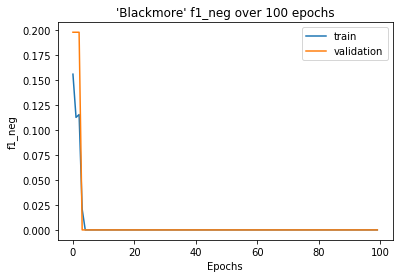

Average Training Score: 0.004046264689059764
Average Validation Score: 0.0059340659340659345
Wrote metrics to 'raw_logs/Blackmore.csv'

validating on book: 'Montaigne'
Creating JQ's net1.
train counts {0: 632, 1: 1519}

Epoch 0/99
----------
Phase:train
average loss 1840.2882015705109
f1_pos 0.7906844646407272
f1_neg 0.056338028169014086
Phase:val
average loss 457.5410699248314
f1_pos 0.8929460580912862
f1_neg 0

Epoch 1/99
----------
Phase:train
average loss 1514.0452659130096
f1_pos 0.8275109170305677
f1_neg 0.009404388714733543
Phase:val
average loss 454.9522867798805
f1_pos 0.8929460580912862
f1_neg 0

Epoch 2/99
----------
Phase:train
average loss 1509.265075147152
f1_pos 0.8277929155313352
f1_neg 0
Phase:val
average loss 454.6174557209015
f1_pos 0.8929460580912862
f1_neg 0

Epoch 3/99
----------
Phase:train
average loss 1507.2888180613518
f1_pos 0.8277929155313352
f1_neg 0
Phase:val
average loss 454.4335030913353
f1_pos 0.8929460580912862
f1_neg 0

Epoch 4/99
----------
Phase:tra

Phase:val
average loss 452.5240939259529
f1_pos 0.8929460580912862
f1_neg 0

Epoch 45/99
----------
Phase:train
average loss 1504.5829743146896
f1_pos 0.8277929155313352
f1_neg 0
Phase:val
average loss 453.3461630344391
f1_pos 0.8929460580912862
f1_neg 0

Epoch 46/99
----------
Phase:train
average loss 1506.3648092746735
f1_pos 0.8277929155313352
f1_neg 0
Phase:val
average loss 452.6153771877289
f1_pos 0.8929460580912862
f1_neg 0

Epoch 47/99
----------
Phase:train
average loss 1505.960749745369
f1_pos 0.8277929155313352
f1_neg 0
Phase:val
average loss 451.82197219133377
f1_pos 0.8929460580912862
f1_neg 0

Epoch 48/99
----------
Phase:train
average loss 1508.0537956953049
f1_pos 0.8277929155313352
f1_neg 0
Phase:val
average loss 450.8816708922386
f1_pos 0.8929460580912862
f1_neg 0

Epoch 49/99
----------
Phase:train
average loss 1505.5668628811836
f1_pos 0.8277929155313352
f1_neg 0
Phase:val
average loss 453.0847718119621
f1_pos 0.8929460580912862
f1_neg 0

Epoch 50/99
----------
Phase

Phase:val
average loss 452.96752566099167
f1_pos 0.8929460580912862
f1_neg 0

Epoch 91/99
----------
Phase:train
average loss 1506.118272304535
f1_pos 0.8277929155313352
f1_neg 0
Phase:val
average loss 453.1577286720276
f1_pos 0.8929460580912862
f1_neg 0

Epoch 92/99
----------
Phase:train
average loss 1503.793388068676
f1_pos 0.8277929155313352
f1_neg 0
Phase:val
average loss 454.22421383857727
f1_pos 0.8929460580912862
f1_neg 0

Epoch 93/99
----------
Phase:train
average loss 1506.1020087599754
f1_pos 0.8277929155313352
f1_neg 0
Phase:val
average loss 454.4545926451683
f1_pos 0.8929460580912862
f1_neg 0

Epoch 94/99
----------
Phase:train
average loss 1506.6127606630325
f1_pos 0.8277929155313352
f1_neg 0
Phase:val
average loss 453.74050056934357
f1_pos 0.8929460580912862
f1_neg 0

Epoch 95/99
----------
Phase:train
average loss 1507.0571631789207
f1_pos 0.8277929155313352
f1_neg 0
Phase:val
average loss 453.3018946647644
f1_pos 0.8929460580912862
f1_neg 0

Epoch 96/99
----------
Phas

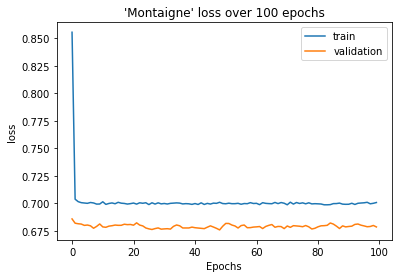

Average Training Score: 0.7016189933532562
Average Validation Score: 0.6792466394261442


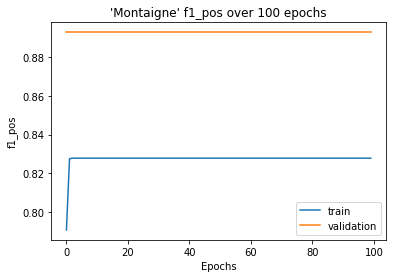

Average Training Score: 0.8274190110374212
Average Validation Score: 0.8929460580912864


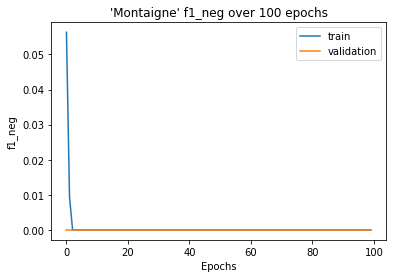

Average Training Score: 0.0006574241688374763
Average Validation Score: 0.0
Wrote metrics to 'raw_logs/Montaigne.csv'

validating on book: 'Allestree'
Creating JQ's net1.
train counts {0: 695, 1: 1845}

Epoch 0/99
----------
Phase:train
average loss 1819.741211116314
f1_pos 0.6961506961506961
f1_neg 0.21453775582215945
Phase:val
average loss 195.61961901187897
f1_pos 0
f1_neg 0.3837209302325581

Epoch 1/99
----------
Phase:train
average loss 1797.4876301884651
f1_pos 0.7233931824095758
f1_neg 0.1406628940986257
Phase:val
average loss 192.15829133987427
f1_pos 0.8653061224489795
f1_neg 0

Epoch 2/99
----------
Phase:train
average loss 1783.0689764618874
f1_pos 0.8415051311288484
f1_neg 0
Phase:val
average loss 191.63100397586823
f1_pos 0.8653061224489795
f1_neg 0

Epoch 3/99
----------
Phase:train
average loss 1777.9600418806076
f1_pos 0.8415051311288484
f1_neg 0
Phase:val
average loss 191.7872874736786
f1_pos 0.8653061224489795
f1_neg 0

Epoch 4/99
----------
Phase:train
average loss 1

Phase:val
average loss 191.5649734735489
f1_pos 0.8653061224489795
f1_neg 0

Epoch 45/99
----------
Phase:train
average loss 1776.6569519639015
f1_pos 0.8415051311288484
f1_neg 0
Phase:val
average loss 191.54046046733856
f1_pos 0.8653061224489795
f1_neg 0

Epoch 46/99
----------
Phase:train
average loss 1776.8830632567406
f1_pos 0.8415051311288484
f1_neg 0
Phase:val
average loss 191.693301320076
f1_pos 0.8653061224489795
f1_neg 0

Epoch 47/99
----------
Phase:train
average loss 1777.2847188711166
f1_pos 0.8415051311288484
f1_neg 0
Phase:val
average loss 191.38995373249054
f1_pos 0.8653061224489795
f1_neg 0

Epoch 48/99
----------
Phase:train
average loss 1777.2234239578247
f1_pos 0.8415051311288484
f1_neg 0
Phase:val
average loss 191.76394069194794
f1_pos 0.8653061224489795
f1_neg 0

Epoch 49/99
----------
Phase:train
average loss 1776.7691197991371
f1_pos 0.8415051311288484
f1_neg 0
Phase:val
average loss 191.69790077209473
f1_pos 0.8653061224489795
f1_neg 0

Epoch 50/99
----------
Ph

Phase:val
average loss 191.64887177944183
f1_pos 0.8653061224489795
f1_neg 0

Epoch 91/99
----------
Phase:train
average loss 1778.5515753626823
f1_pos 0.8415051311288484
f1_neg 0
Phase:val
average loss 191.33292198181152
f1_pos 0.8653061224489795
f1_neg 0

Epoch 92/99
----------
Phase:train
average loss 1775.2653449177742
f1_pos 0.8415051311288484
f1_neg 0
Phase:val
average loss 191.77931082248688
f1_pos 0.8653061224489795
f1_neg 0

Epoch 93/99
----------
Phase:train
average loss 1779.370453953743
f1_pos 0.8415051311288484
f1_neg 0
Phase:val
average loss 191.64779365062714
f1_pos 0.8653061224489795
f1_neg 0

Epoch 94/99
----------
Phase:train
average loss 1775.0322217941284
f1_pos 0.8415051311288484
f1_neg 0
Phase:val
average loss 191.53876423835754
f1_pos 0.8653061224489795
f1_neg 0

Epoch 95/99
----------
Phase:train
average loss 1775.2911006212234
f1_pos 0.8415051311288484
f1_neg 0
Phase:val
average loss 191.5954018831253
f1_pos 0.8653061224489795
f1_neg 0

Epoch 96/99
----------
P

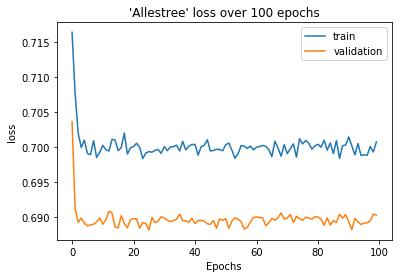

Average Training Score: 0.7001798473019301
Average Validation Score: 0.6896906937926794


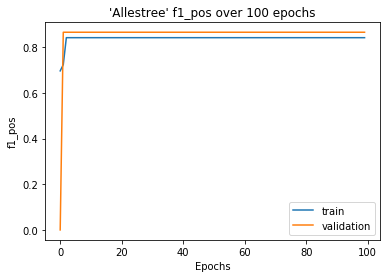

Average Training Score: 0.8388704672918741
Average Validation Score: 0.8566530612244898


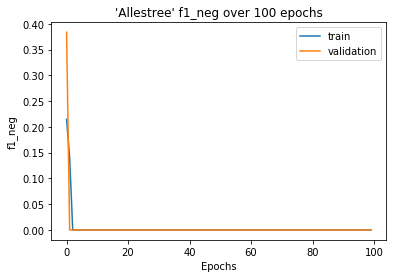

Average Training Score: 0.0035520064992078516
Average Validation Score: 0.003837209302325581
Wrote metrics to 'raw_logs/Allestree.csv'

validating on book: 'Browne'
Creating JQ's net1.
train counts {0: 601, 1: 1857}

Epoch 0/99
----------
Phase:train
average loss 2232.388835966587
f1_pos 0.7989090007438632
f1_neg 0.08154020385050963
Phase:val
average loss 248.8302779197693
f1_pos 0
f1_neg 0.6153846153846153

Epoch 1/99
----------
Phase:train
average loss 1713.9820564389229
f1_pos 0.8483423465788855
f1_neg 0.027149321266968323
Phase:val
average loss 259.8650884628296
f1_pos 0.7142857142857143
f1_neg 0

Epoch 2/99
----------
Phase:train
average loss 1709.1034939289093
f1_pos 0.8607184241019699
f1_neg 0
Phase:val
average loss 258.4138584136963
f1_pos 0.7142857142857143
f1_neg 0

Epoch 3/99
----------
Phase:train
average loss 1710.5278061032295
f1_pos 0.8607184241019699
f1_neg 0
Phase:val
average loss 261.19787216186523
f1_pos 0.7142857142857143
f1_neg 0

Epoch 4/99
----------
Phase:train


Phase:val
average loss 260.0759381055832
f1_pos 0.7142857142857143
f1_neg 0

Epoch 45/99
----------
Phase:train
average loss 1709.4932518601418
f1_pos 0.8607184241019699
f1_neg 0
Phase:val
average loss 261.62219166755676
f1_pos 0.7142857142857143
f1_neg 0

Epoch 46/99
----------
Phase:train
average loss 1706.2333472967148
f1_pos 0.8607184241019699
f1_neg 0
Phase:val
average loss 259.4728082418442
f1_pos 0.7142857142857143
f1_neg 0

Epoch 47/99
----------
Phase:train
average loss 1706.982074022293
f1_pos 0.8607184241019699
f1_neg 0
Phase:val
average loss 258.01285684108734
f1_pos 0.7142857142857143
f1_neg 0

Epoch 48/99
----------
Phase:train
average loss 1712.7986853718758
f1_pos 0.8607184241019699
f1_neg 0
Phase:val
average loss 261.8202418088913
f1_pos 0.7142857142857143
f1_neg 0

Epoch 49/99
----------
Phase:train
average loss 1708.213835299015
f1_pos 0.8607184241019699
f1_neg 0
Phase:val
average loss 260.8385318517685
f1_pos 0.7142857142857143
f1_neg 0

Epoch 50/99
----------
Phase

Phase:val
average loss 260.81840217113495
f1_pos 0.7142857142857143
f1_neg 0

Epoch 91/99
----------
Phase:train
average loss 1708.5970984697342
f1_pos 0.8607184241019699
f1_neg 0
Phase:val
average loss 261.63994789123535
f1_pos 0.7142857142857143
f1_neg 0

Epoch 92/99
----------
Phase:train
average loss 1706.0764733552933
f1_pos 0.8607184241019699
f1_neg 0
Phase:val
average loss 258.2566601037979
f1_pos 0.7142857142857143
f1_neg 0

Epoch 93/99
----------
Phase:train
average loss 1710.0300448536873
f1_pos 0.8607184241019699
f1_neg 0
Phase:val
average loss 260.211598277092
f1_pos 0.7142857142857143
f1_neg 0

Epoch 94/99
----------
Phase:train
average loss 1709.9379807710648
f1_pos 0.8607184241019699
f1_neg 0
Phase:val
average loss 260.68402886390686
f1_pos 0.7142857142857143
f1_neg 0

Epoch 95/99
----------
Phase:train
average loss 1708.8634719848633
f1_pos 0.8607184241019699
f1_neg 0
Phase:val
average loss 260.1556259393692
f1_pos 0.7142857142857143
f1_neg 0

Epoch 96/99
----------
Pha

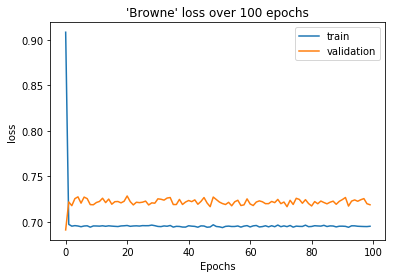

Average Training Score: 0.6974102003626264
Average Validation Score: 0.7216850441197556


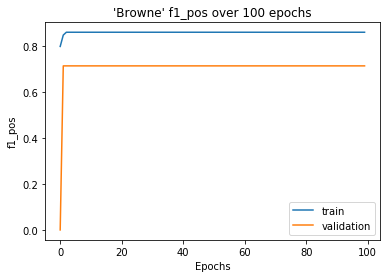

Average Training Score: 0.8599765690931582
Average Validation Score: 0.707142857142857


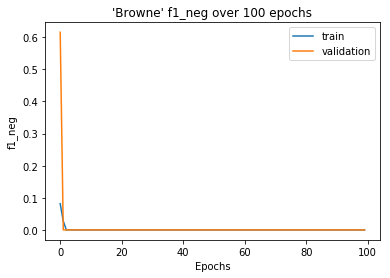

Average Training Score: 0.0010868952511747796
Average Validation Score: 0.006153846153846153
Wrote metrics to 'raw_logs/Browne.csv'

validating on book: 'Albin'
Creating JQ's net1.
train counts {0: 618, 1: 2026}

Epoch 0/99
----------
Phase:train
average loss 2066.9734295606613
f1_pos 0.7866966741685422
f1_neg 0.3382467028704422
Phase:val
average loss 126.40814316272736
f1_pos 0.30243902439024395
f1_neg 0

Epoch 1/99
----------
Phase:train
average loss 1853.8289206027985
f1_pos 0.8588692274492877
f1_neg 0
Phase:val
average loss 123.22170948982239
f1_pos 0.30243902439024395
f1_neg 0

Epoch 2/99
----------
Phase:train
average loss 1850.7355765104294
f1_pos 0.8673097534833869
f1_neg 0.006420545746388444
Phase:val
average loss 121.6514321565628
f1_pos 0.30243902439024395
f1_neg 0

Epoch 3/99
----------
Phase:train
average loss 1849.5992864370346
f1_pos 0.8676659528907924
f1_neg 0
Phase:val
average loss 122.11630618572235
f1_pos 0.30243902439024395
f1_neg 0

Epoch 4/99
----------
Phase:trai

Phase:train
average loss 1846.7708052396774
f1_pos 0.8676659528907924
f1_neg 0
Phase:val
average loss 125.60597634315491
f1_pos 0.30243902439024395
f1_neg 0

Epoch 45/99
----------
Phase:train
average loss 1844.6780997514725
f1_pos 0.8676659528907924
f1_neg 0
Phase:val
average loss 122.63682186603546
f1_pos 0.30243902439024395
f1_neg 0

Epoch 46/99
----------
Phase:train
average loss 1849.3034082651138
f1_pos 0.8676659528907924
f1_neg 0
Phase:val
average loss 123.84653723239899
f1_pos 0.30243902439024395
f1_neg 0

Epoch 47/99
----------
Phase:train
average loss 1845.0848643183708
f1_pos 0.8676659528907924
f1_neg 0
Phase:val
average loss 122.02837908267975
f1_pos 0.30243902439024395
f1_neg 0

Epoch 48/99
----------
Phase:train
average loss 1849.3782302737236
f1_pos 0.8676659528907924
f1_neg 0
Phase:val
average loss 123.6808352470398
f1_pos 0.30243902439024395
f1_neg 0

Epoch 49/99
----------
Phase:train
average loss 1847.9540172815323
f1_pos 0.8676659528907924
f1_neg 0
Phase:val
average

Phase:val
average loss 123.23861908912659
f1_pos 0.30243902439024395
f1_neg 0

Epoch 90/99
----------
Phase:train
average loss 1846.2614862918854
f1_pos 0.8676659528907924
f1_neg 0
Phase:val
average loss 122.06164479255676
f1_pos 0.30243902439024395
f1_neg 0

Epoch 91/99
----------
Phase:train
average loss 1847.9870423674583
f1_pos 0.8676659528907924
f1_neg 0
Phase:val
average loss 122.43458223342896
f1_pos 0.30243902439024395
f1_neg 0

Epoch 92/99
----------
Phase:train
average loss 1847.3426141738892
f1_pos 0.8676659528907924
f1_neg 0
Phase:val
average loss 122.74889826774597
f1_pos 0.30243902439024395
f1_neg 0

Epoch 93/99
----------
Phase:train
average loss 1846.4244567751884
f1_pos 0.8676659528907924
f1_neg 0
Phase:val
average loss 121.90936696529388
f1_pos 0.30243902439024395
f1_neg 0

Epoch 94/99
----------
Phase:train
average loss 1849.3439289927483
f1_pos 0.8676659528907924
f1_neg 0
Phase:val
average loss 123.0953961610794
f1_pos 0.30243902439024395
f1_neg 0

Epoch 95/99
-----

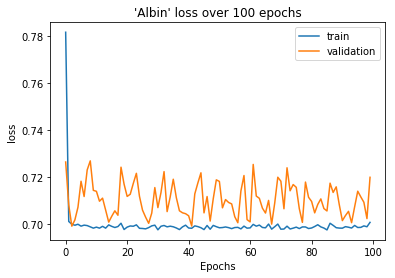

Average Training Score: 0.6996715410597026
Average Validation Score: 0.7104961418351907


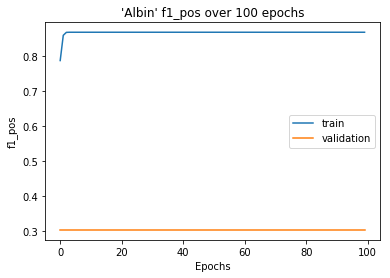

Average Training Score: 0.8667647308550808
Average Validation Score: 0.30243902439024395


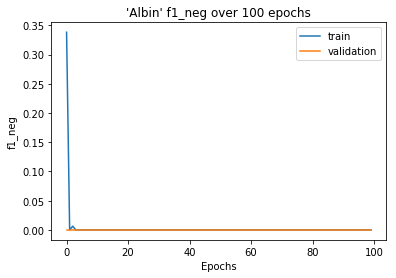

Average Training Score: 0.003446672486168306
Average Validation Score: 0.0
Wrote metrics to 'raw_logs/Albin.csv'

validating on book: 'Dryden'
Creating JQ's net1.
train counts {0: 722, 1: 2048}

Epoch 0/99
----------
Phase:train
average loss 2415.195707499981
f1_pos 0.7575471698113208
f1_neg 0.20923076923076922
Phase:val
average loss 29.34290313720703
f1_pos 0
f1_neg 0.896551724137931

Epoch 1/99
----------
Phase:train
average loss 1959.7361311912537
f1_pos 0.7465051258154706
f1_neg 0.1282051282051282
Phase:val
average loss 33.60204792022705
f1_pos 0.3157894736842105
f1_neg 0

Epoch 2/99
----------
Phase:train
average loss 1945.4578687548637
f1_pos 0.8501452885014529
f1_neg 0
Phase:val
average loss 34.477972984313965
f1_pos 0.3157894736842105
f1_neg 0

Epoch 3/99
----------
Phase:train
average loss 1939.4871622920036
f1_pos 0.8501452885014529
f1_neg 0
Phase:val
average loss 34.97058391571045
f1_pos 0.3157894736842105
f1_neg 0

Epoch 4/99
----------
Phase:train
average loss 1937.1607202

Phase:train
average loss 1941.43199634552
f1_pos 0.8501452885014529
f1_neg 0
Phase:val
average loss 34.406928062438965
f1_pos 0.3157894736842105
f1_neg 0

Epoch 46/99
----------
Phase:train
average loss 1940.4570221304893
f1_pos 0.8501452885014529
f1_neg 0
Phase:val
average loss 34.46469211578369
f1_pos 0.3157894736842105
f1_neg 0

Epoch 47/99
----------
Phase:train
average loss 1938.8744994401932
f1_pos 0.8501452885014529
f1_neg 0
Phase:val
average loss 34.39682579040527
f1_pos 0.3157894736842105
f1_neg 0

Epoch 48/99
----------
Phase:train
average loss 1941.143670141697
f1_pos 0.8501452885014529
f1_neg 0
Phase:val
average loss 34.04634475708008
f1_pos 0.3157894736842105
f1_neg 0

Epoch 49/99
----------
Phase:train
average loss 1938.7793110609055
f1_pos 0.8501452885014529
f1_neg 0
Phase:val
average loss 34.02581977844238
f1_pos 0.3157894736842105
f1_neg 0

Epoch 50/99
----------
Phase:train
average loss 1940.879123389721
f1_pos 0.8501452885014529
f1_neg 0
Phase:val
average loss 34.367

Phase:train
average loss 1937.3515093326569
f1_pos 0.8501452885014529
f1_neg 0
Phase:val
average loss 34.57286739349365
f1_pos 0.3157894736842105
f1_neg 0

Epoch 92/99
----------
Phase:train
average loss 1938.405878186226
f1_pos 0.8501452885014529
f1_neg 0
Phase:val
average loss 34.27488899230957
f1_pos 0.3157894736842105
f1_neg 0

Epoch 93/99
----------
Phase:train
average loss 1942.9385505318642
f1_pos 0.8501452885014529
f1_neg 0
Phase:val
average loss 34.22889804840088
f1_pos 0.3157894736842105
f1_neg 0

Epoch 94/99
----------
Phase:train
average loss 1941.4316319227219
f1_pos 0.8501452885014529
f1_neg 0
Phase:val
average loss 34.1804895401001
f1_pos 0.3157894736842105
f1_neg 0

Epoch 95/99
----------
Phase:train
average loss 1938.886507987976
f1_pos 0.8501452885014529
f1_neg 0
Phase:val
average loss 33.85351753234863
f1_pos 0.3157894736842105
f1_neg 0

Epoch 96/99
----------
Phase:train
average loss 1941.3621903657913
f1_pos 0.8501452885014529
f1_neg 0
Phase:val
average loss 33.880

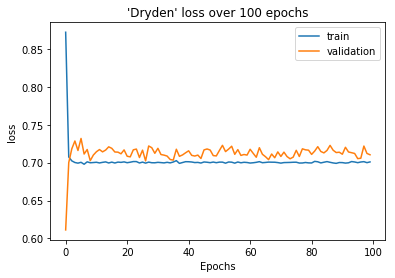

Average Training Score: 0.7020895627207705
Average Validation Score: 0.7122405678033829


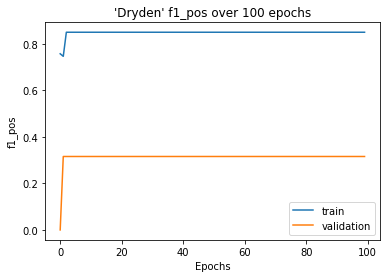

Average Training Score: 0.8481829056876918
Average Validation Score: 0.3126315789473684


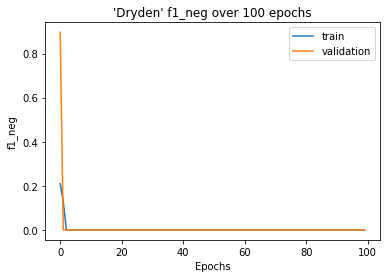

Average Training Score: 0.003374358974358974
Average Validation Score: 0.00896551724137931
Wrote metrics to 'raw_logs/Dryden.csv'

validating on book: 'Defoe'
Creating JQ's net1.
train counts {0: 654, 1: 1828}

Epoch 0/99
----------
Phase:train
average loss 2069.745999634266
f1_pos 0.7620570210498268
f1_neg 0.26259289843104877
Phase:val
average loss 230.97102427482605
f1_pos 0
f1_neg 0.48306997742663654

Epoch 1/99
----------
Phase:train
average loss 1752.0259485840797
f1_pos 0.7020408163265306
f1_neg 0.15050426687354537
Phase:val
average loss 235.37080538272858
f1_pos 0.8106194690265487
f1_neg 0

Epoch 2/99
----------
Phase:train
average loss 1727.731207549572
f1_pos 0.8482598607888632
f1_neg 0
Phase:val
average loss 235.3501056432724
f1_pos 0.8106194690265487
f1_neg 0

Epoch 3/99
----------
Phase:train
average loss 1729.128899693489
f1_pos 0.8482598607888632
f1_neg 0
Phase:val
average loss 236.13061273097992
f1_pos 0.8106194690265487
f1_neg 0

Epoch 4/99
----------
Phase:train
averag

Phase:val
average loss 236.24845933914185
f1_pos 0.8106194690265487
f1_neg 0

Epoch 45/99
----------
Phase:train
average loss 1729.4681451320648
f1_pos 0.8482598607888632
f1_neg 0
Phase:val
average loss 236.48093330860138
f1_pos 0.8106194690265487
f1_neg 0

Epoch 46/99
----------
Phase:train
average loss 1725.8394854068756
f1_pos 0.8482598607888632
f1_neg 0
Phase:val
average loss 235.8674064874649
f1_pos 0.8106194690265487
f1_neg 0

Epoch 47/99
----------
Phase:train
average loss 1725.6289755702019
f1_pos 0.8482598607888632
f1_neg 0
Phase:val
average loss 236.26508033275604
f1_pos 0.8106194690265487
f1_neg 0

Epoch 48/99
----------
Phase:train
average loss 1726.8491242527962
f1_pos 0.8482598607888632
f1_neg 0
Phase:val
average loss 235.91910123825073
f1_pos 0.8106194690265487
f1_neg 0

Epoch 49/99
----------
Phase:train
average loss 1727.9318192005157
f1_pos 0.8482598607888632
f1_neg 0
Phase:val
average loss 235.70148301124573
f1_pos 0.8106194690265487
f1_neg 0

Epoch 50/99
----------


Phase:val
average loss 236.38652288913727
f1_pos 0.8106194690265487
f1_neg 0

Epoch 91/99
----------
Phase:train
average loss 1726.1158896684647
f1_pos 0.8482598607888632
f1_neg 0
Phase:val
average loss 236.62949573993683
f1_pos 0.8106194690265487
f1_neg 0

Epoch 92/99
----------
Phase:train
average loss 1726.0323151350021
f1_pos 0.8482598607888632
f1_neg 0
Phase:val
average loss 236.73373019695282
f1_pos 0.8106194690265487
f1_neg 0

Epoch 93/99
----------
Phase:train
average loss 1726.952065706253
f1_pos 0.8482598607888632
f1_neg 0
Phase:val
average loss 236.44675731658936
f1_pos 0.8106194690265487
f1_neg 0

Epoch 94/99
----------
Phase:train
average loss 1725.4355869293213
f1_pos 0.8482598607888632
f1_neg 0
Phase:val
average loss 235.94651055335999
f1_pos 0.8106194690265487
f1_neg 0

Epoch 95/99
----------
Phase:train
average loss 1728.431829214096
f1_pos 0.8482598607888632
f1_neg 0
Phase:val
average loss 236.0467791557312
f1_pos 0.8106194690265487
f1_neg 0

Epoch 96/99
----------
Ph

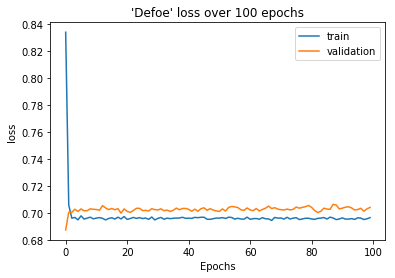

Average Training Score: 0.6974664918205414
Average Validation Score: 0.7026035424712158


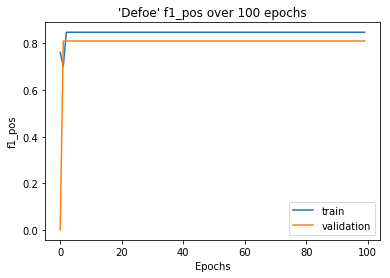

Average Training Score: 0.8459356419468491
Average Validation Score: 0.802513274336283


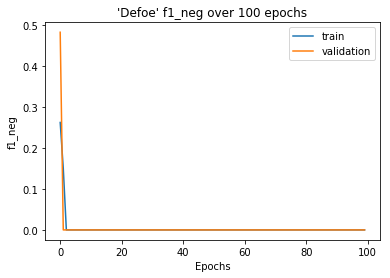

Average Training Score: 0.004130971653045942
Average Validation Score: 0.004830699774266365
Wrote metrics to 'raw_logs/Defoe.csv'

validating on book: 'Confucius'
Creating JQ's net1.
train counts {0: 755, 1: 1892}

Epoch 0/99
----------
Phase:train
average loss 3236.382471561432
f1_pos 0.6518750000000001
f1_neg 0.4680038204393505
Phase:val
average loss 146.7677594423294
f1_pos 0
f1_neg 0.06779661016949151

Epoch 1/99
----------
Phase:train
average loss 1918.0147721767426
f1_pos 0.5602094240837696
f1_neg 0.18534482758620688
Phase:val
average loss 120.3332325220108
f1_pos 0
f1_neg 0.06779661016949151

Epoch 2/99
----------
Phase:train
average loss 1870.3319848179817
f1_pos 0.6948763701249044
f1_neg 0.12691466083150985
Phase:val
average loss 116.66876894235611
f1_pos 0.9821428571428572
f1_neg 0

Epoch 3/99
----------
Phase:train
average loss 1867.4171050786972
f1_pos 0.776210625293841
f1_neg 0.08461538461538462
Phase:val
average loss 113.73855638504028
f1_pos 0.9821428571428572
f1_neg 0



Phase:val
average loss 114.33412665128708
f1_pos 0.9821428571428572
f1_neg 0

Epoch 44/99
----------
Phase:train
average loss 1858.3722595572472
f1_pos 0.8336638025996916
f1_neg 0
Phase:val
average loss 115.03605061769485
f1_pos 0.9821428571428572
f1_neg 0

Epoch 45/99
----------
Phase:train
average loss 1859.6669518351555
f1_pos 0.8336638025996916
f1_neg 0
Phase:val
average loss 115.30641847848892
f1_pos 0.9821428571428572
f1_neg 0

Epoch 46/99
----------
Phase:train
average loss 1861.134011387825
f1_pos 0.8336638025996916
f1_neg 0
Phase:val
average loss 115.04635775089264
f1_pos 0.9821428571428572
f1_neg 0

Epoch 47/99
----------
Phase:train
average loss 1860.6269011497498
f1_pos 0.8336638025996916
f1_neg 0
Phase:val
average loss 114.93329674005508
f1_pos 0.9821428571428572
f1_neg 0

Epoch 48/99
----------
Phase:train
average loss 1860.02447783947
f1_pos 0.8336638025996916
f1_neg 0
Phase:val
average loss 113.4614787697792
f1_pos 0.9821428571428572
f1_neg 0

Epoch 49/99
----------
Pha

Phase:val
average loss 115.40499490499496
f1_pos 0.9821428571428572
f1_neg 0

Epoch 89/99
----------
Phase:train
average loss 1859.1310307383537
f1_pos 0.8336638025996916
f1_neg 0
Phase:val
average loss 116.13439857959747
f1_pos 0.9821428571428572
f1_neg 0

Epoch 90/99
----------
Phase:train
average loss 1860.8950984477997
f1_pos 0.7833993937980882
f1_neg 0.07562189054726369
Phase:val
average loss 116.0961167216301
f1_pos 0.9821428571428572
f1_neg 0

Epoch 91/99
----------
Phase:train
average loss 1857.889504134655
f1_pos 0.8136967785537282
f1_neg 0.032748538011695916
Phase:val
average loss 117.04612773656845
f1_pos 0.9821428571428572
f1_neg 0

Epoch 92/99
----------
Phase:train
average loss 1862.9991213679314
f1_pos 0.770867817450934
f1_neg 0.09014084507042253
Phase:val
average loss 115.77479708194733
f1_pos 0.9821428571428572
f1_neg 0

Epoch 93/99
----------
Phase:train
average loss 1863.504242181778
f1_pos 0.8336638025996916
f1_neg 0
Phase:val
average loss 114.83218508958817
f1_pos 

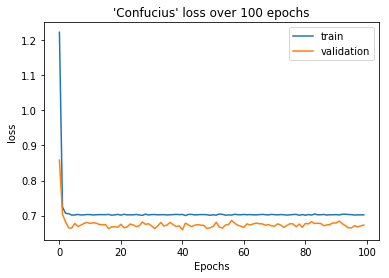

Average Training Score: 0.7080721863119117
Average Validation Score: 0.6753100849487628


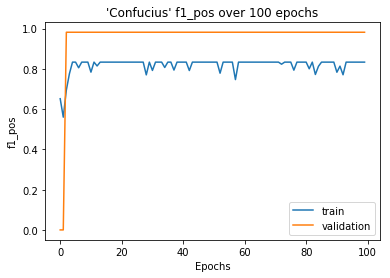

Average Training Score: 0.819651616324503
Average Validation Score: 0.9625000000000006


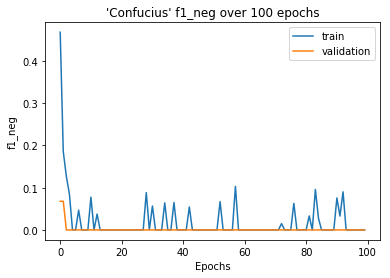

Average Training Score: 0.01958246507177507
Average Validation Score: 0.0013559322033898302
Wrote metrics to 'raw_logs/Confucius.csv'

training complete


In [12]:
# ========================================
# Step 5. execute the train process
# ========================================

# overriding to use CPU when GPU is busy
use_gpu = True
print('use_gpu is ' + str(use_gpu))


phases = ['train', 'val']
metric_types = ['loss', 'tn', 'fp', 'fn', 'tp', 'f1_pos', 'f1_neg']
metric_types_plot = ['loss', 'f1_pos', 'f1_neg']
metric_names_all = [p+'-'+m for p in phases for m in metric_types]
metric_names_plot = [p+'-'+m for p in phases for m in metric_types_plot]

all_metrics = {book : {metric : [] for metric in metric_names_all} for book in books_in_data}

# train parameters
# num_training_epochs = 5
num_training_epochs = 100

# leave-one-book-out cross validation
for val_book in books_in_data:
    print("validating on book: '" + str(val_book) + "'")
    
    # define the train and validation loaders
    train_books = books_in_data - set([val_book])
    cross_val_loaders = {}
    cross_val_loaders["train"] = {b : book_data_loaders[b]["train"] for b in train_books}
    cross_val_loaders["val"] = {b : book_data_loaders[b]["val"] for b in [val_book]}
    
    # get the model architecture
    model = create_model_architecture('jq_net1')
    
    # model hyperparameters
    # check weights added to CrossEntropyLoss [1, 1/(#pos in train / #neg in train)]
    train_counts = {c : sum([image_counts[b][c] for b in train_books]) for c in [0,1]}
    print('train counts', train_counts)
    loss_weights = torch.FloatTensor([1, float(train_counts[0])/float(train_counts[1])])
    if use_gpu:
        loss_weights = loss_weights.cuda()
    else:
        loss_weights = loss_weights.cpu()
    criterion = nn.CrossEntropyLoss(weight = loss_weights)
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    
    # train
    trained_model, train_metrics = train(model,
                                         criterion,
                                         optimizer,
                                         cross_val_loaders,
                                         num_epochs=num_training_epochs)
    
    # update metrics dicts
    all_metrics[str(val_book)] = train_metrics
    
    # plot all metrics
    for metric in metric_types_plot:
        plot_values(all_metrics[str(val_book)]['train-' + str(metric)],
                   all_metrics[str(val_book)]['val-' + str(metric)],
                   "'" + str(val_book) + "' " + str(metric) + " over " + str(num_training_epochs) + " epochs",
                   ylabel = str(metric))
        
    # write metrics to file
    write_metrics_to_csv(all_metrics[str(val_book)], metric_names_all, 'raw_logs', str(val_book) + '.csv')
    
    print()
    
    # remove the break as needed
#     break


print("training complete")

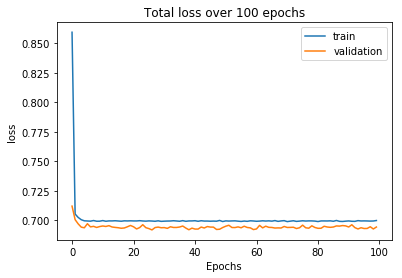

Average Training Score: 0.701202448327815
Average Validation Score: 0.6944361494916629


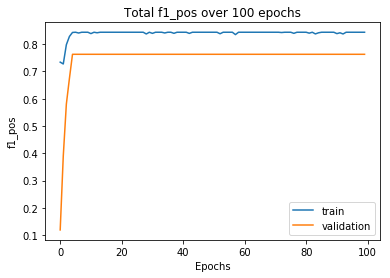

Average Training Score: 0.839785270987518
Average Validation Score: 0.7497822734931674


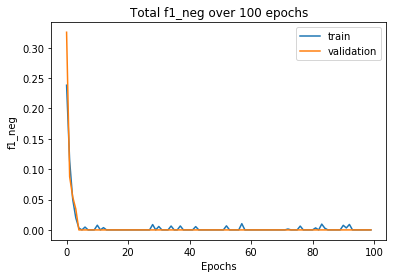

Average Training Score: 0.005343966133507128
Average Validation Score: 0.005017157887682614


In [13]:
# compute and plot total loss
# total_train_loss = [sum([all_train_loss[b][i] for b in all_train_loss]) for i in range(num_training_epochs)]
# total_val_loss = [sum([all_val_loss[b][i] for b in all_val_loss]) for i in range(num_training_epochs)]
# plot_losses(total_train_loss, total_val_loss, "Total losses over " + str(num_training_epochs) + " epochs")

total_metrics = {metric : [np.mean([all_metrics[book][metric][epoch] for book in all_metrics])
                           for epoch in range(num_training_epochs)]
                 for metric in metric_names_plot}

for metric in metric_types_plot:
    plot_values(total_metrics['train-' + str(metric)],
                   total_metrics['val-' + str(metric)],
                   "Total " + str(metric) + " over " + str(num_training_epochs) + " epochs",
                   ylabel = str(metric))
